This notebook produces the analysis and figures of the paper. Please run the cells in order to avoid inconsistencies.

In [1]:
import sys

# add the paths of the two systems
sys.path.append('../data/wq')
sys.path.append('../data/chignolin')

# import all the functions for data production analysis
from utils import *

# neural network device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# plots
AIMMD_RFPS_color = 'tomato'
AIMMD_TPS_color = 'dodgerblue'
AIMMD_RFPS_front_color = 'red'
AIMMD_TPS_front_color = 'blue'
AIMMD_RFPS_back_color = 'lightsalmon'
AIMMD_TPS_back_color = 'deepskyblue'
TPS_color = 'darkviolet'
EQ_color = 'black'

/home/lazzeri/anaconda3/envs/aimmd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# WQ system

In [43]:
# main parameters
system = '../data/wq'
name = system.split('/')[-1]

# integrator
dt = 100  # interval between frames [dt]
nsteps_ceil = 2500

# states definition
xA, yA = +0.21427517601479118, +1.874640867926128  # minimum A
xB, yB = -0.25538755928343726, -1.845107485478632  # minimum B
radius = .5

# plotting parameters
potential_energy_levels = np.arange(-14, 4)
reaction_coordinate_levels = np.arange(-14, 15, 2)

# contour plots: fine-grid matrices
X = np.load(f'{system}/reference/grid_X.npy')
Y = np.load(f'{system}/reference/grid_Y.npy')
V = np.load(f'{system}/reference/grid_V.npy')
Q = logit(np.load(f'{system}/reference/grid_committor_relaxation.npy'))
P = (np.load(f'{system}/reference/grid_boltzmann_distribution.npy'))

# reference free energies
reference_pe = PathEnsemble().load(f'{system}/reference/pe.h5')
reference_tpe = PathEnsemble().load(f'{system}/reference/tpe.h5')
reference_tpe.frame_values = Q.ravel()

# restrict grid
b = +220, +220
e = len(X)-220, len(X)-220
X = X[b[0]:e[0], b[1]:e[1]]
Y = Y[b[0]:e[0], b[1]:e[1]]
V = V[b[0]:e[0], b[1]:e[1]]
Q = Q[b[0]:e[0], b[1]:e[1]]
P = P[b[0]:e[0], b[1]:e[1]]
XY = np.array(list(zip(X.ravel(), Y.ravel())))

# contour plots: coarse-grid matrices
Xr = X[::10, ::10]
Yr = Y[::10, ::10]
Vr = V[::10, ::10]
Pr = P[::10, ::10]
XYr = np.array(list(zip(Xr.ravel(), Yr.ravel())))
Xc = (Xr[1:, 1:] + Xr[:-1, :-1]) / 2
Yc = (Yr[1:, 1:] + Yr[:-1, :-1]) / 2
Vc = (Vr[1:, 1:] + Vr[:-1, :-1]) / 2
XYc = np.array(list(zip(Xc.ravel(), Yc.ravel())))

# channel distances
reference_trajectory_in_channel1 = md.load(
    f'{system}/reference_trajectory_in_channel_I.xtc',
    top=f'{system}/run.gro').xyz[:, 0, :2]

reference_trajectory_in_channel2 = md.load(
    f'{system}/reference_trajectory_in_channel_II.xtc',
    top=f'{system}/run.gro').xyz[:, 0, :2]

import scipy
def compute_channels_dist(positions):
    """
    Given a trajectory, returns a CV telling how close it is to
    the first and second rective channel, based on the Hausdorff
    distance to the reference trajectories.
    """
    u = positions
    v = reference_trajectory_in_channel1
    d1 =  min(scipy.spatial.distance.directed_hausdorff(u, v)[0],
              scipy.spatial.distance.directed_hausdorff(v, u)[0])
    v = reference_trajectory_in_channel2
    d2 =  min(scipy.spatial.distance.directed_hausdorff(u, v)[0],
              scipy.spatial.distance.directed_hausdorff(v, u)[0])
    return (d1 - d2) / (d1 + d2)

def compute_channels_switches(series,
                      channel1_threshold=-.5,
                      channel2_threshold=+.5):
    """
    Given a "channels_dist" time series, returns the positions
    of the reactive channel switches.
    """
    switches = []
    series = np.array(series)
    step_numbers = np.arange(len(series))
    current_status = 0
    for s, step_number in zip(series, step_numbers):
        if s < channel1_threshold  and (current_status in [0, 2]):
            if current_status:
                switches.append(step_number)
            current_status = 1
        elif s > channel2_threshold and (current_status in [0, 1]):
            if current_status:
                switches.append(step_number)
            current_status = 2
    return switches 

# true committor model as a fake NN
class Network0(torch.nn.Module):
    
    def __init__(self, grid_X=np.load(f'{system}/reference/grid_X.npy'),
        grid_Y=np.load(f'{system}/reference/grid_Y.npy'),
        true_committor_grid=np.load(f'{system}/reference/grid_committor_relaxation.npy')):
        super().__init__()
        self.call_kwargs = {}
        # layers & activations
        self.layer1 = torch.nn.Linear(1, 1)
        grid_x_bins = grid_X[0, :]
        self.grid_x_bins = np.concatenate(
            [grid_x_bins[:-1] - np.diff(grid_x_bins) / 2,
             grid_x_bins[-2:] + np.diff(grid_x_bins[-3:]) / 2])
        grid_y_bins = grid_Y[:, 0]
        self.grid_y_bins = np.concatenate(
            [grid_y_bins[:-1] - np.diff(grid_y_bins) / 2,
             grid_y_bins[-2:] + np.diff(grid_y_bins[-3:]) / 2])
        self.true_committor_grid = logit(true_committor_grid)
        self.reset_parameters()
    def forward(self, positions):
        xy = positions.detach().cpu().numpy()
        i = np.clip(np.digitize(xy[:, 0], self.grid_x_bins) - 1,
                    0, len(self.grid_x_bins) - 2)
        j = np.clip(np.digitize(xy[:, 1], self.grid_y_bins) - 1,
                    0, len(self.grid_y_bins) - 2)
        output_values = self.true_committor_grid[j, i]
        return torch.reshape(torch.tensor(output_values, dtype=torch.get_default_dtype()), (-1, 1)).to(device)
    def reset_parameters(self):
        self.layer1.reset_parameters()

# precomputed values for TS error
xr, yr = np.meshgrid(np.arange(-2.5,2.55,.25), np.arange(-2.5,2.55,.25))
Z0_TS_error = reference_tpe.project([xr[0, :], yr[:, 0]], vmin=-.4, vmax=+.4, f=lambda x:x)
Z0_TS_error /= np.sum(Z0_TS_error)
Z0_TS_error = Z0_TS_error.ravel()
Z0_TS_error = -np.log(Z0_TS_error)

/tmp/ipykernel_3538842/1419432047.py:134: RuntimeWarning: divide by zero encountered in log
  Z0_TS_error = -np.log(Z0_TS_error)


## System presentation

0


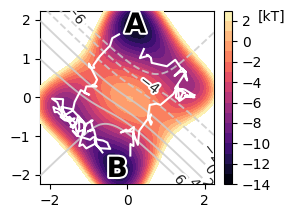

In [44]:
figure, ax = plot_2d_energy(X, Y, V, potential_energy_levels,
               P=Q, rc_levels=reaction_coordinate_levels[4:-4],
              xA=xA,yA=yA,xB=xB,yB=yB)
ax.plot(*reference_trajectory_in_channel1[::10].T,
        color='white', zorder=100)
ax.plot(*reference_trajectory_in_channel2[::10].T,
        color='white', zorder=100)
plt.savefig(f'figures/{name}_2d_true.pdf')

## Load equilibrium simulation results

In [45]:
equilibrium = PathEnsemble()
equilibrium.load(f'{system}/equilibrium/transitions.h5')
equilibrium.frame_values = evaluate(
    Network0(), equilibrium.frame_descriptors)

# estimate reference transition rates (evolution)
(kAB0, kBA0, kAB0_max, kBA0_max, kAB0_min, kBA0_min,
 TP_length, TP_length_max, TP_length_min, times0) = (
    estimate_transition_rates_from_equilibrium(equilibrium, dt=dt))

dkAB0 = (kAB0_max - kAB0_min) / 4
dkBA0 = (kBA0_max - kBA0_min) / 4
print('Transition rates from a long equilibrium simulation')
print(f'{kAB0[-1]:.3e} +- {100*dkAB0[-1]/kAB0[-1]:.2f}% '
      f'out of {len(kAB0) // 2} events')
print(f'{kBA0[-1]:.3e} +- {100*dkBA0[-1]/kBA0[-1]:.2f}% '
      f'out of {len(kAB0) // 2} events')

mfrt = 1 / kAB0[-1] + 1 / kBA0[-1]
print(f'Mean first return time: {mfrt:.3e} [dt]')

Transition rates from a long equilibrium simulation
1.038e-09 +- 4.70% out of 460 events
2.017e-09 +- 4.59% out of 460 events
Mean first return time: 1.459e+09 [dt]


## Load uniform TPS simulation results

In [46]:
tps = PathEnsemble()
tps.load(f'{system}/uniform_tps/chain.h5')
tps.frame_values = evaluate(
    Network0(), tps.frame_descriptors)

## Load and analyze AIMMD results (fixed budget)

Run the following cells for all directories and computational budgets to obtain the related figures in main text and Supplental Material of the paper.

In [6]:
directory = 'fps0'
budget = .1 * mfrt
#budget = 10 * mfrt

if 'fps' in directory:
    base_color = AIMMD_RFPS_color
else:
    base_color = AIMMD_TPS_color

# load params settings (NN architecture, states definition,
#                       reweight parameters, etc.)
cwd = os.getcwd()
os.chdir(f'{system}/{directory}')
exec(open(f'params.py', 'r').read())
os.chdir(cwd)

# update reference path ensembles settings
reference_pe.states_function = states_function
reference_pe.descriptors_function = descriptors_function
reference_pe.values_function = values_function
reference_tpe.states_function = states_function
reference_tpe.descriptors_function = descriptors_function
reference_tpe.values_function = values_function

# load all simulations in PathEnsemble objects
print(f'loading run AIMMD {directory}')
Pathensemble = load_pathensemble(
    states_function, descriptors_function, values_function,
    directory=f'{system}/{directory}')
Shots, EquilibriumA, EquilibriumB = scorporate_pathensembles(Pathensemble)

# exclude simulations after computational budget
completion_times = np.sort(Pathensemble.frame_simulation_times)
tmax = completion_times[min(int(budget / dt), len(completion_times) - 1)]
tmax = min(tmax, Shots.completion_times[-1])
step_number = int(min(np.ceil(np.sum(
    Shots.completion_times <= tmax) / 10.) * 10, nsteps_ceil))
print(f'\ncomputational budget: {budget:.3e} [dt] ({budget/mfrt:.3f} mfrt)')
pathensemble = crop_pathensemble(Pathensemble, step_number)
shots, equilibriumA, equilibriumB = scorporate_pathensembles(pathensemble)

# retrieve the NN model at the time of the computational budget
network = Network().to(device)
try:
    network.load_state_dict(torch.load(
        f'{system}/{directory}/network{step_number:06g}.h5',
        map_location=device))
except:  # retrain on the available data if the parameters are not present
    network, *_ = fit(Network(), pathensemble, verbose=True)

# update pathensembles CV values
pathensemble.update_values()
reference_pe.update_values()
reference_tpe.update_values()

# get SP selection bins
bins = get_bins(pathensemble, n_bins)

# reweight
(wA, path_indicesA, internal_segmentsA, excursionsA,
 xPA, mA, extremesA, shooting_valuesA, factorsA) = pathensemble.reweight(
     'A', **reweight_parameters)
(wB, path_indicesB, internal_segmentsB, excursionsB,
 xPB, mB, extremesB, shooting_valuesB, factorsB) = pathensemble.reweight(
     'B', **reweight_parameters)

# estimate transition rates
pathensemble.weights = wA
kAB = 1 / (pathensemble.project()[0] * dt)
pathensemble.weights = wB
kBA = 1 / (pathensemble.project()[0] * dt)

# report
print(f'Step {step_number:5}: '
      f'nT = {np.sum(shots.are_transitions):<5.0f} '
      f'kAB = {kAB:.2e} (/ref = {kAB/kAB0[-1]:.2e}), '
      f'kBA = {kBA:.2e} (/ref = {kBA/kBA0[-1]:.2e})')

# accepted moves
if 'tps' in directory:
    print('accepted moves: ', np.sum(np.load(
        f'{system}/{directory}/shots0/chain_weights.npy')[:step_number] > 0))

loading AIMMD fps0 run
shots: Union of 1 non-empty PathEnsemble instances, 2501 paths from 2501 trajectory files, 3069443 individual frames
    chain 0: 2501 paths, 396 transitions, last updated 7114610 s ago
equilibriumA: Union of 1 non-empty PathEnsemble instances, 74339 paths from 84 trajectory files, 4186926 individual frames
equilibriumB: Union of 1 non-empty PathEnsemble instances, 81745 paths from 84 trajectory files, 4179789 individual frames

computational budget: 1.459e+08 [dt] (0.100 mfrt)
Step   370: nT = 44    kAB = 9.56e-10 (/ref = 9.21e-01), kBA = 3.55e-09 (/ref = 1.76e+00)


### 1D free energy projection

/home/lazzeri/projects/aimmd/analysis/../data/wq/utils.py:1858: RuntimeWarning: divide by zero encountered in log
  F0 = -np.log(result)
/home/lazzeri/projects/aimmd/analysis/../data/wq/utils.py:1879: RuntimeWarning: divide by zero encountered in log
  F = -np.log(result)


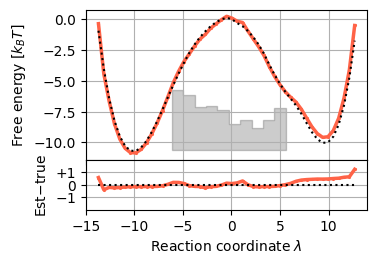

In [7]:
pathensemble.weights = wA + wB
figure, axes = plot_1d_energy_profile(pathensemble,
                                      reference_pe,
                                      nbins=101,
                                      vmin=-np.inf,
                                      vmax=+np.inf,
                                      pathensemble_bootstrapping=0,
                                      reference_bootstrapping=0,
                                      reweight_parameters=reweight_parameters,
                                      offset=0,
                                      max_error=2.,
                                      base_color=base_color,
                                      SP_selection_bins=bins)
plt.savefig(f'figures/{name}_{directory}_{len(shots)}_free.pdf')

### 2D free energy projection (difference)

0


/tmp/ipykernel_3538842/2094604499.py:7: RuntimeWarning: divide by zero encountered in divide
  plot_2d_energy(Xc, Yc, np.log(Z0 / Z),


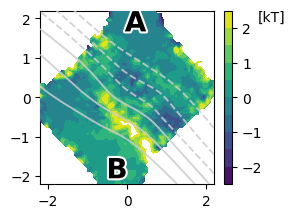

In [8]:
max_error = 2.5
pathensemble.weights = wA + wB
Z = project_on_grid(pathensemble, Xr, Yr)
Z0 = np.exp(-Vc)
Z0 /= np.sum(Z0)

plot_2d_energy(Xc, Yc, np.log(Z0 / Z),
               np.arange(-max_error, max_error + .5, .5),
               Xc, Yc, evaluate(network, XYc).reshape(Xc.shape),
               rc_levels=bins[::2],
               rc_labels=False,
               cmap='viridis',
               xA=xA, yA=yA,
               xB=xB, yB=yB,
               wrmse=0.)

plt.savefig(f'figures/{name}_{directory}_{len(shots)}_2d_diff.pdf')

### 2D TPE projection (difference)

/tmp/ipykernel_3538842/2933254109.py:11: RuntimeWarning: divide by zero encountered in divide
  plot_2d_energy(Xc, Yc, np.log(Z0 / Z),
/tmp/ipykernel_3538842/2933254109.py:11: RuntimeWarning: invalid value encountered in divide
  plot_2d_energy(Xc, Yc, np.log(Z0 / Z),


0


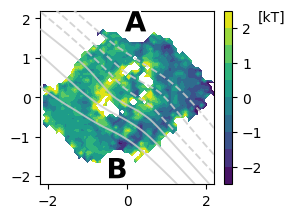

In [9]:
if 'fps' in directory:
    pathensemble.weights = (wA + wB) * pathensemble.are_transitions
else:
    pathensemble.weights = 0.
    shots.weights = np.load(f'{system}/{directory}/shots0/chain_weights.npy')

transitions = pathensemble[pathensemble.are_transitions]  # faster
Z = project_on_grid(transitions, Xr, Yr)
Z0 = project_on_grid(reference_tpe, Xr, Yr)

plot_2d_energy(Xc, Yc, np.log(Z0 / Z),
               np.arange(-max_error, max_error + .5, .5),
               Xc, Yc, evaluate(network, XYc).reshape(Xc.shape),
               rc_levels=bins[::2],
               rc_labels=False,
               cmap='viridis',
               xA=xA, yA=yA,
               xB=xB, yB=yB,
               wrmse=0.)

plt.savefig(f'figures/{name}_{directory}_{len(shots)}_2d_tpe_diff.pdf')

### TS error

In [10]:
_network = network
network = Network0()
transitions.update_values()
Z = transitions.project([xr[0, :], yr[:, 0]], vmin=-.4, vmax=+.4, f=lambda x:x)
Z /= np.sum(Z)
Z = Z.ravel()
Z = -np.log(Z)
Z0 = Z0_TS_error
keepers = (Z0 - np.min(Z0)) < 2.5
Z = Z[keepers]
Z0 = Z0[keepers]
Z = np.minimum(Z, Z0 + 2.5)
network = _network

TS_error = np.sqrt(np.mean((Z - Z0) ** 2))
print(f'TS_error = {TS_error:.2f}')

TS_error = 0.77


/tmp/ipykernel_3538842/3287055949.py:7: RuntimeWarning: divide by zero encountered in log
  Z = -np.log(Z)


## All 1D free energies together

### Defining bins and model

In [11]:
# params
network_model = f'{system}/fps0/network000370.h5'
budget = 0.1 * mfrt

# model
network = Network().to(device)
network.load_state_dict(torch.load(network_model, map_location=device))
reference_pe.frame_values = evaluate(network, reference_pe.frame_descriptors)

# bins
vmin = np.max([-30, np.min(np.concatenate(reference_pe.values(reference_pe.weights > 0)))])
vmax = np.min([+30, np.max(np.concatenate(reference_pe.values(reference_pe.weights > 0)))])
bins = np.linspace(vmin, vmax, 101 + 1)
A = (bins[:-1] + bins[1:]) / 2
print(f'vmin: {vmin:.3f}, vmax: {vmax:.3f}')

# reference free energy
p0 = reference_pe.project(bins)
p0 /= np.sum(p0)
f0 = -np.log(p0)
offset = -f0[np.argmin(np.abs(A))]
f0 += offset

vmin: -27.714, vmax: 27.811


/tmp/ipykernel_3538842/3845694534.py:20: RuntimeWarning: divide by zero encountered in log
  f0 = -np.log(p0)


### Computation

In [13]:
directories = [f'fps{i}' if 'fps' in network_model
               else f'tps{i}' for i in range(10)]
profiles = []

for directory in directories:
    # load params settings (NN architecture, states definition,
    #                       reweight parameters, etc.)
    cwd = os.getcwd()
    os.chdir(f'{system}/{directory}')
    exec(open(f'params.py', 'r').read())
    os.chdir(cwd)
    
    # load all simulations in PathEnsemble objects
    print(f'loading run AIMMD {directory}')
    Pathensemble = load_pathensemble(
        states_function, descriptors_function, values_function,
        directory=f'{system}/{directory}')
    Shots, EquilibriumA, EquilibriumB = scorporate_pathensembles(Pathensemble)
    print()
    
    # exclude simulations after computational budget
    completion_times = np.sort(Pathensemble.frame_simulation_times)
    tmax = completion_times[min(int(budget / dt), len(completion_times) - 1)]
    tmax = min(tmax, Shots.completion_times[-1])
    step_number = int(min(np.ceil(np.sum(
        Shots.completion_times <= tmax) / 10.) * 10., nsteps_ceil))
    pathensemble = crop_pathensemble(Pathensemble, step_number)
    shots, equilibriumA, equilibriumB = scorporate_pathensembles(pathensemble)
    
    # retrieve the NN model at the time of the computational budget
    network = Network().to(device)
    try:
        network.load_state_dict(torch.load(
            f'{system}/{directory}/network{step_number:06g}.h5',
            map_location=device))
    except:  # retrain on the available data if the parameters are not present
        network, *_ = fit(Network(), pathensemble, verbose=True)
    
    # update pathensemble CV values
    pathensemble.update_values()
    
    # reweight
    (wA, path_indicesA, internal_segmentsA, excursionsA,
     xPA, mA, extremesA, shooting_valuesA, factorsA) = pathensemble.reweight(
         'A', **reweight_parameters)
    (wB, path_indicesB, internal_segmentsB, excursionsB,
     xPB, mB, extremesB, shooting_valuesB, factorsB) = pathensemble.reweight(
         'B', **reweight_parameters)
    
    # back to reference model
    network = Network().to(device)
    network.load_state_dict(
        torch.load(network_model, map_location=device))
    pathensemble.update_values()
    
    # do projection
    pathensemble.weights = wA + wB
    profiles.append(pathensemble.project(bins))

loading AIMMD fps0 run
shots: Union of 1 non-empty PathEnsemble instances, 2501 paths from 2501 trajectory files, 3069443 individual frames
    chain 0: 2501 paths, 396 transitions, last updated 7115231 s ago
equilibriumA: Union of 1 non-empty PathEnsemble instances, 74339 paths from 84 trajectory files, 4186926 individual frames
equilibriumB: Union of 1 non-empty PathEnsemble instances, 81745 paths from 84 trajectory files, 4179789 individual frames

loading AIMMD fps1 run
shots: Union of 1 non-empty PathEnsemble instances, 2502 paths from 2502 trajectory files, 2769292 individual frames
    chain 0: 2502 paths, 393 transitions, last updated 6618194 s ago
equilibriumA: Union of 2 non-empty PathEnsemble instances, 63107 paths from 74 trajectory files, 3632086 individual frames
equilibriumB: Union of 1 non-empty PathEnsemble instances, 71947 paths from 73 trajectory files, 3639988 individual frames

loading AIMMD fps2 run
shots: Union of 1 non-empty PathEnsemble instances, 2501 paths fr

### Plot results

/tmp/ipykernel_3538842/82336141.py:14: RuntimeWarning: divide by zero encountered in log
  f = -np.log(profiles[i] / np.sum(profiles[i])) + offset
/tmp/ipykernel_3538842/82336141.py:21: RuntimeWarning: divide by zero encountered in log
  f = -np.log(profiles[0] / np.sum(profiles[0])) + offset


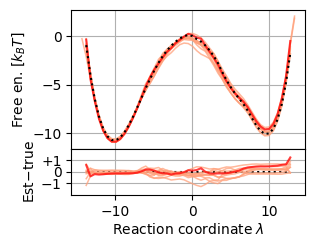

In [15]:
figure, (ax1, ax2) = plt.subplots(2,1,
                                      figsize=(3,2.5),
                                      sharex=True,
                                      gridspec_kw={'height_ratios': [3, 1]})

if 'fps' in network_model:
    back_color = AIMMD_RFPS_back_color
    front_color = AIMMD_RFPS_front_color
else:
    back_color = AIMMD_TPS_back_color
    front_color = AIMMD_TPS_front_color

for i in range(1, 10):
    f = -np.log(profiles[i] / np.sum(profiles[i])) + offset
    ax1.plot(A, f,
             color=back_color, lw=1.1,
             zorder=10, alpha=.75)
    ax2.plot(A, f-f0,
             color=back_color, lw=1.1,
             zorder=10, alpha=.75)
f = -np.log(profiles[0] / np.sum(profiles[0])) + offset
ax1.plot(A, f,
         color=front_color, lw=1.5,
         zorder=20, alpha=.75)
ax2.plot(A, f-f0,
         color=front_color, lw=1.5,
         zorder=20, alpha=.75)

f0[np.isinf(f)] = np.nan
ax1.plot(A, f0, ':', color='black', zorder=30)
ax2.plot(A, f0*0., ':', color='black')

ax2.set_ylim(-2,2)
ax1.grid()
ax2.grid()
plt.minorticks_off()
ax2.set_xlabel('Reaction coordinate $\lambda$', labelpad=2.5)
ax1.set_ylabel('Free en. [$k_BT$]')
ax2.set_ylabel('Est$-$true', labelpad=2.5)
plt.subplots_adjust(left=0.2105, bottom=0.16, right=0.99,
                    top=0.9, hspace=0)

ylim = ax1.get_ylim()
ax2.set_yticks([-1, 0., 1], ['$-$1','0','+1'])
plt.savefig(
    f'figures/{name}_{network_model.split("/")[-1]}_budget_{budget/mfrt}_1d.pdf')

## AIMMD channel switches

In [16]:
directories = [f'fps{i}' for i in range(10)] + [
               f'tps{i}' for i in range(10)]
budget = 10 * mfrt  # too high
print(f'computational budget: {budget:.3e} [dt] ({budget/mfrt} mfrt)\n')

channels_times = []
channels_dists = []
channels_switches = []

for directory in directories:
    print(f'*** {directory} ***')
    
    # load data
    Pathensemble = load_pathensemble(
    states_function, descriptors_function, values_function,
    directory=f'{system}/{directory}')
    Shots, EquilibriumA, EquilibriumB = scorporate_pathensembles(Pathensemble)

    # exclude simulations after computational budget
    completion_times = np.sort(Pathensemble.frame_simulation_times)
    tmax = completion_times[min(int(budget / dt), len(completion_times) - 1)]
    tmax = min(tmax, Shots.completion_times[-1])
    step_number = int(min(np.ceil(np.sum(
        Shots.completion_times <= tmax) / 10.) * 10, nsteps_ceil))
    pathensemble = crop_pathensemble(Pathensemble, step_number)
    shots, equilibriumA, equilibriumB = scorporate_pathensembles(pathensemble)

    # focus on transitions
    k = Shots.are_transitions
    
    # times
    channels_times.append(np.cumsum(Shots.internal_lengths)[k] * dt)
    
    # dists
    channels_dists.append(np.array(
        [compute_channels_dist(d) for d in Shots.descriptors(k)]))
    
    # switches
    channels_switches.append(
        compute_channels_switches(channels_dists[-1]))

    # plot statistics
    n_switches = len(channels_switches[-1])
    nT = len(channels_times[-1])
    total_time = np.sum(Shots.internal_lengths) * dt
    
    print(f'\n{directory}: {n_switches} switches')
    print(f'  a switch every '
              f'{nT / n_switches:.1f} TPs\n'
    f'                 {len(Shots) / n_switches:.1f} steps\n'
    f'                 {total_time / n_switches:.3e} [dt]\n'
    f'                 {total_time / n_switches / mfrt:.3e} [mfrt]\n\n')


computational budget: 1.459e+10 [dt] (10.0 mfrt)

*** fps0 ***
shots: Union of 1 non-empty PathEnsemble instances, 2501 paths from 2501 trajectory files, 3069443 individual frames
    chain 0: 2501 paths, 396 transitions, last updated 7115822 s ago
equilibriumA: Union of 1 non-empty PathEnsemble instances, 74339 paths from 84 trajectory files, 4186926 individual frames
equilibriumB: Union of 1 non-empty PathEnsemble instances, 81745 paths from 84 trajectory files, 4179789 individual frames

fps0: 18 switches
  a switch every 22.0 TPs
                 138.9 steps
                 1.702e+07 [dt]
                 1.167e-02 [mfrt]


*** fps1 ***
shots: Union of 1 non-empty PathEnsemble instances, 2502 paths from 2502 trajectory files, 2769292 individual frames
    chain 0: 2502 paths, 393 transitions, last updated 6618783 s ago
equilibriumA: Union of 2 non-empty PathEnsemble instances, 63107 paths from 74 trajectory files, 3632086 individual frames
equilibriumB: Union of 1 non-empty PathEn

### Plot example with equilibrium and uniform TPS data

equilibrium: 278 switches
  a switch every 3.3 TPs
                 3.3 steps
                 2.411e+09 [dt]
                 1.652e+00 [mfrt]

uniform tps: 34 switches
  a switch every 62.9 TPs
                 62.9 steps
                 1.969e+08 [dt]
                 1.349e-01 [mfrt]


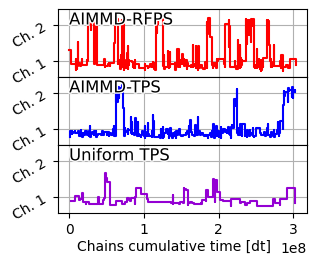

In [18]:
# RFPS-AIMMD data (will plot the first one)
aimmd_fps_channels_times = channels_times[0]
aimmd_fps_channels_dists = channels_dists[0]
aimmd_fps_channels_switches = channels_switches[0]

max_t = aimmd_fps_channels_times[-1]  # [dt] chain length

# AIMMD (TPS) data (will plot the first one)
aimmd_tps_channels_times = channels_times[10]
aimmd_tps_channels_dists = channels_dists[10]
aimmd_tps_channels_switches = channels_switches[10]

# equilibrium data
eq_channels_times = times0
eq_channels_dists = np.array(
    [compute_channels_dist(d) for d in equilibrium.descriptors()])
eq_channels_switches = compute_channels_switches(eq_channels_dists)

n_switches = len(eq_channels_switches)
nT = len(eq_channels_times)
total_time = eq_channels_times[-1]
print(f'equilibrium: {n_switches} switches')
print(f'  a switch every '
          f'{nT / n_switches:.1f} TPs\n'
f'                 {nT / n_switches:.1f} steps\n'
f'                 {total_time / n_switches:.3e} [dt]\n'
f'                 {total_time / n_switches / mfrt:.3e} [mfrt]\n')


# uniform tps data
tps_channels_times = tps.completion_times
tps_channels_dists = np.array(
    [compute_channels_dist(d) for d in tps.descriptors()])
tps_channels_switches = compute_channels_switches(tps_channels_dists)

n_switches = len(tps_channels_switches)
nT = len(tps_channels_times)
total_time = tps_channels_times[-1]
print(f'uniform tps: {n_switches} switches')
print(f'  a switch every '
          f'{nT / n_switches:.1f} TPs\n'
f'                 {nT / n_switches:.1f} steps\n'
f'                 {total_time / n_switches:.3e} [dt]\n'
f'                 {total_time / n_switches / mfrt:.3e} [mfrt]')

fig, ax = plt.subplots(
    3, 1, sharex=True, figsize=(3, 2.5),
    gridspec_kw={'hspace': 0})
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.99, top=0.975)

ax[0].set_yticks([-.54, +.54], ['Ch. 1', 'Ch. 2'], rotation=30)
ax[1].set_yticks([-.54, +.54], ['Ch. 1', 'Ch. 2'], rotation=30)
ax[2].set_yticks([-.54, +.54], ['Ch. 1', 'Ch. 2'], rotation=30)
ax[0].set_ylim(-1.02, 1.02)
ax[1].set_ylim(-1.02, 1.02)
ax[2].set_ylim(-1.02, 1.02)
ax[0].grid()
ax[1].grid()
ax[2].grid()

t = np.repeat(aimmd_fps_channels_times, 2)[1:]
c = np.repeat(aimmd_fps_channels_dists, 2)[:-1]
ax[0].plot(t[t<max_t], c[t<max_t], color=AIMMD_RFPS_front_color)
t = ax[0].text(-.18, .567, 'RFPS-AIMMD', fontsize=11.8)
plt.setp(t, path_effects=[pe.withStroke(linewidth=2, foreground="w")])

t = np.repeat(aimmd_tps_channels_times, 2)[1:]
c = np.repeat(aimmd_tps_channels_dists, 2)[:-1]
ax[1].plot(t[t<max_t], c[t<max_t], color=AIMMD_TPS_front_color)
t = ax[1].text(-.18, .567, 'AIMMD', fontsize=11.8)
plt.setp(t, path_effects=[pe.withStroke(linewidth=2, foreground="w")])

t = np.repeat(tps_channels_times, 2)[1:]
c = np.repeat(tps_channels_dists, 2)[:-1]
ax[2].plot(t[t<max_t], c[t<max_t], color=TPS_color)
t = ax[2].text(-.18, .567, 'Uniform TPS', fontsize=11.8)
plt.setp(t, path_effects=[pe.withStroke(linewidth=2, foreground="w")])

ax[2].set_xlabel('Chains cumulative time [dt]    ', labelpad=2)
plt.savefig(f'figures/{name}_switches.pdf')

### Plot all together

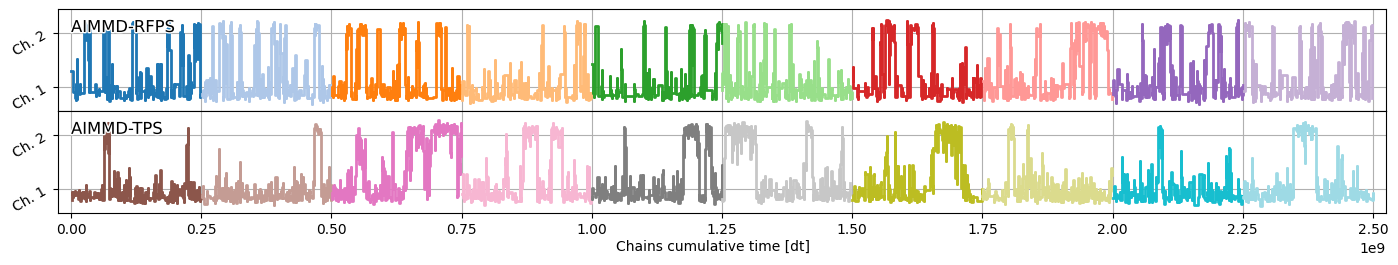

In [19]:
max_t = 2.5e8  # [dt] chain length

fig, ax = plt.subplots(
    2, 1, sharex=True, figsize=(16, 2.5),
    gridspec_kw={'hspace': 0})
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.99, top=0.975)

ax[0].set_yticks([-.54, +.54], ['Ch. 1', 'Ch. 2'], rotation=30)
ax[1].set_yticks([-.54, +.54], ['Ch. 1', 'Ch. 2'], rotation=30)
ax[0].set_ylim(-1.02, 1.02)
ax[1].set_ylim(-1.02, 1.02)
ax[0].grid()
ax[1].grid()

for i in range(10):
    aimmd_fps_channels_times = channels_times[i].astype(float)
    aimmd_fps_channels_dists = channels_dists[i]
    keepers = aimmd_fps_channels_times < max_t
    aimmd_fps_channels_times = aimmd_fps_channels_times[keepers]
    aimmd_fps_channels_dists = aimmd_fps_channels_dists[keepers]
    aimmd_fps_channels_times += max_t * i
    t = np.repeat(aimmd_fps_channels_times, 2)[1:]
    c = np.repeat(aimmd_fps_channels_dists, 2)[:-1]
    ax[0].plot(t, c, color=plt.get_cmap('tab20')(i), lw=2)
t = ax[0].text(-.18, .567, 'RFPS-AIMMD', fontsize=11.8)
plt.setp(t, path_effects=[pe.withStroke(linewidth=2, foreground="w")])

for i in range(10, 20):
    aimmd_tps_channels_times = channels_times[i].astype(float)
    aimmd_tps_channels_dists = channels_dists[i]
    keepers = aimmd_tps_channels_times < max_t
    aimmd_tps_channels_times = aimmd_tps_channels_times[keepers]
    aimmd_tps_channels_dists = aimmd_tps_channels_dists[keepers]
    aimmd_tps_channels_times += max_t * (i - 10)
    t = np.repeat(aimmd_tps_channels_times, 2)[1:]
    c = np.repeat(aimmd_tps_channels_dists, 2)[:-1]
    ax[1].plot(t, c, color=plt.get_cmap('tab20')(i), lw=2)
t = ax[1].text(-.18, .567, 'AIMMD', fontsize=11.8)
plt.setp(t, path_effects=[pe.withStroke(linewidth=2, foreground="w")])
plt.xlim(-max_t * .1, max_t * 10.1)
ax[0].set_xticks(np.arange(0, max_t*11, max_t))

ax[1].set_xlabel('Chains cumulative time [dt]    ', labelpad=2)
plt.savefig(f'figures/{name}_switches_all.pdf')

## Rates estimates and error at TS evolution

### Compute estimates of the AIMMD runs

In [47]:
directories = [f'fps{i}' for i in range(10)] + [
               f'tps{i}' for i in range(10)]
step_numbers = np.array([
        10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
        120, 140, 160, 180, 200, 220, 250,
        280, 310, 340, 370, 400, 450, 500,
        550, 600, 650, 700, 750, 800, 900, 1000,
        1100, 1250, 1500, 1750, 2000, 2500])

kAB = []
kBA = []
times = []
TS_error = []

for directory in directories:

    # initialize empty time and estimate lists
    times.append([])
    kAB.append([])
    kBA.append([])
    TS_error.append([])
    
    # load params settings (NN architecture, states definition,
    #                       reweight parameters, etc.)
    cwd = os.getcwd()
    os.chdir(f'{system}/{directory}')
    exec(open(f'params.py', 'r').read())
    os.chdir(cwd)
    
    # load all simulations in PathEnsemble objects
    print(f'loading run AIMMD {directory}')
    Pathensemble = load_pathensemble(
        states_function, descriptors_function, values_function,
        directory=f'{system}/{directory}')
    Shots, EquilibriumA, EquilibriumB = scorporate_pathensembles(Pathensemble)
    print()
    
    for step_number in step_numbers:
        
        # exclude simulations after step_number
        pathensemble = crop_pathensemble(Pathensemble, step_number)
        shots, equilibriumA, equilibriumB = scorporate_pathensembles(pathensemble)
        
        # retrieve the NN model at the time of the computational budget
        network = Network().to(device)
        try:
            network.load_state_dict(torch.load(
                f'{system}/{directory}/network{step_number:06g}.h5',
                map_location=device))
        except:  # retrain on the available data if the parameters are not present
            network, *_ = fit(Network(), pathensemble, verbose=True)
        
        # update pathensemble CV values
        pathensemble.update_values()
        
        # reweight
        (wA, path_indicesA, internal_segmentsA, excursionsA,
         xPA, mA, extremesA, shooting_valuesA, factorsA) = pathensemble.reweight(
             'A', **reweight_parameters)
        (wB, path_indicesB, internal_segmentsB, excursionsB,
         xPB, mB, extremesB, shooting_valuesB, factorsB) = pathensemble.reweight(
             'B', **reweight_parameters)
        
        # estimate transition rates
        pathensemble.weights = wA
        kAB[-1].append(1 / (pathensemble.project()[0] * dt))
        pathensemble.weights = wB
        kBA[-1].append(1 / (pathensemble.project()[0] * dt))
        times[-1].append(np.sum(pathensemble.internal_lengths) * dt)
        
        # report
        print(f'Step {step_number:5}: '
              f'nT = {np.sum(shots.are_transitions):<5.0f} '
              f'kAB = {kAB[-1][-1]:.2e} (/ref = {kAB[-1][-1]/kAB0[-1]:.2e}), '
              f'kBA = {kBA[-1][-1]:.2e} (/ref = {kBA[-1][-1]/kBA0[-1]:.2e})')
        
        # accepted moves
        if 'tps' in directory:
            print('accepted moves: ', np.sum(np.load(
                f'{system}/{directory}/shots0/chain_weights.npy')[:step_number] > 0))

        # retrieve transitions with correct weights
        if 'fps' in directory:
            pathensemble.weights = (wA + wB) * pathensemble.are_transitions
        else:
            pathensemble.weights = 0.
            shots.weights = np.load(f'{system}/{directory}/shots0/chain_weights.npy')
        
        transitions = pathensemble[pathensemble.are_transitions]  # faster
        
        # TS error
        network = Network0()
        transitions.update_values()
        if not len(transitions):
            TS_error[-1].append(np.nan)
            continue
        
        Z = transitions.project([xr[0, :], yr[:, 0]], vmin=-.4, vmax=+.4, f=lambda x:x)
        Z /= np.sum(Z)
        Z = Z.ravel()
        Z = -np.log(Z)
        Z0 = Z0_TS_error
        keepers = (Z0 - np.min(Z0)) < 2.5
        Z = Z[keepers]
        Z0 = Z0[keepers]
        Z = np.minimum(Z, Z0 + 2.5)
        TS_error[-1].append(np.sqrt(np.mean((Z - Z0) ** 2)))
        print(f'TS_error = {TS_error[-1][-1]:.2f}\n')

times = np.array(times)
kAB = np.array(kAB)
kBA = np.array(kBA)

loading run AIMMD fps0
shots: Union of 1 non-empty PathEnsemble instances, 2501 paths from 2501 trajectory files, 3069443 individual frames
    chain 0: 2501 paths, 396 transitions, last updated 7140223 s ago
equilibriumA: Union of 1 non-empty PathEnsemble instances, 74339 paths from 84 trajectory files, 4186926 individual frames
equilibriumB: Union of 1 non-empty PathEnsemble instances, 81745 paths from 84 trajectory files, 4179789 individual frames

Step    10: nT = 1     kAB = 9.97e-08 (/ref = 9.60e+01), kBA = 2.30e-08 (/ref = 1.14e+01)
TS_error = 2.05



/tmp/ipykernel_3538842/2211487254.py:101: RuntimeWarning: divide by zero encountered in log
  Z = -np.log(Z)


Step    20: nT = 2     kAB = 1.08e-07 (/ref = 1.04e+02), kBA = 2.05e-09 (/ref = 1.01e+00)
TS_error = 1.99

Step    30: nT = 2     kAB = 6.48e-08 (/ref = 6.24e+01), kBA = 2.66e-09 (/ref = 1.32e+00)
TS_error = 1.98

Step    40: nT = 3     kAB = 1.71e-08 (/ref = 1.65e+01), kBA = 2.53e-09 (/ref = 1.26e+00)
TS_error = 1.71

Step    50: nT = 5     kAB = 5.19e-09 (/ref = 5.00e+00), kBA = 4.48e-09 (/ref = 2.22e+00)
TS_error = 1.84

Step    60: nT = 6     kAB = 7.03e-09 (/ref = 6.78e+00), kBA = 2.89e-09 (/ref = 1.44e+00)
TS_error = 1.78

Step    70: nT = 7     kAB = 6.00e-09 (/ref = 5.78e+00), kBA = 3.41e-09 (/ref = 1.69e+00)
TS_error = 1.91

Step    80: nT = 7     kAB = 1.85e-09 (/ref = 1.78e+00), kBA = 4.25e-09 (/ref = 2.11e+00)
TS_error = 1.76

Step    90: nT = 7     kAB = 1.07e-09 (/ref = 1.03e+00), kBA = 3.82e-09 (/ref = 1.89e+00)
TS_error = 1.86

Step   100: nT = 9     kAB = 2.09e-09 (/ref = 2.02e+00), kBA = 1.76e-09 (/ref = 8.73e-01)
TS_error = 1.88

Step   120: nT = 9     kAB = 5.43e-10

### Compute TS error of reference

In [48]:
# estimate reference TS error
TS_error0 = []
for i in tqdm(range(len(equilibrium)), position=0):
    Z = equilibrium.project(
        key=np.arange(i+1), bins=[xr[0, :], yr[:, 0]],
        vmin=-.4, vmax=+.4, f=lambda x:x)
    Z /= np.sum(Z)
    Z = Z.ravel()
    Z = -np.log(Z)
    Z0 = Z0_TS_error
    keepers = (Z0 - np.min(Z0)) < 2.5
    Z = Z[keepers]
    Z0 = Z0[keepers]
    Z = np.minimum(Z, Z0 + 2.5)
    TS_error0.append(np.sqrt(np.mean((Z - Z0) ** 2)))

# estimate uniform tps TS error
tps_TS_error = []
for i in tqdm(range(len(tps)), position=0):
    Z = tps.project(
        key=np.arange(i), bins=[xr[0, :], yr[:, 0]],
        vmin=-.4, vmax=+.4, f=lambda x:x)
    Z /= np.sum(Z)
    Z = Z.ravel()
    Z = -np.log(Z)
    Z0 = Z0_TS_error
    keepers = (Z0 - np.min(Z0)) < 2.5
    Z = Z[keepers]
    Z0 = Z0[keepers]
    Z = np.minimum(Z, Z0 + 2.5)
    tps_TS_error.append(np.sqrt(np.mean((Z - Z0) ** 2)))

  0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_3538842/282307398.py:9: RuntimeWarning: divide by zero encountered in log
  Z = -np.log(Z)
  0%|          | 0/2139 [00:00<?, ?it/s]/tmp/ipykernel_3538842/282307398.py:23: RuntimeWarning: invalid value encountered in divide
  Z /= np.sum(Z)
/tmp/ipykernel_3538842/282307398.py:25: RuntimeWarning: divide by zero encountered in log
  Z = -np.log(Z)
100%|██████████| 2139/2139 [00:52<00:00, 40.45it/s]


### Plot RFPS-AIMMD runs estimates

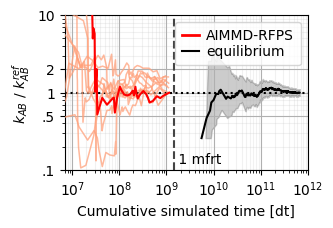

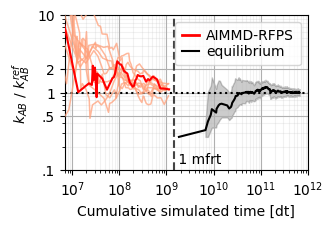

In [49]:
# kAB plot
initialize_plot()

# AIMMD estimates
for i in range(1, 10):
    plt.plot(times[i], kAB[i] / kAB0[-1],
             color=AIMMD_RFPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[0], kAB[0] / kAB0[-1],
         color=AIMMD_RFPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# equilibrium reference estimates
plt.plot(0,0, lw=2, color=AIMMD_RFPS_front_color, label='RFPS-AIMMD')
plt.fill_between(times0[3::2], kAB0_min[3::2]/kAB0[-1],
                 kAB0_max[3::2]/kAB0[-1], alpha=.2,
                 color='black')
plt.plot(times0[::2], kAB0[::2]/kAB0[-1],
         color=EQ_color, label='equilibrium')


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.grid(which='minor', alpha=.167)
plt.legend(labelspacing=.1,
           borderpad=.5,
           handletextpad=.5,
           handlelength=1.25,
          loc='upper right')

ax = plt.gca()
ax.margins(0.025)
plt.xlim(7e6, 1e12)
xlim = ax.get_xlim()
ax.axhline(1., color='black', linestyle=':', zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(.1, 10)
plt.ylim(.1, 10)
ax.set_yticks([.1,.5, 1, 2, 10],['.1', '.5', '1', '2', '10'])
plt.xlabel('Cumulative simulated time [dt]')
plt.ylabel('$k_{AB}~/~k_{AB}^{ref}$')
plt.axvline(mfrt, linestyle='--', color='#444444', zorder=2)
plt.text(mfrt, .12, ' 1 mfrt', ha='left')
plt.savefig(f'figures/{name}_kAB_fps.pdf')

# kBA plot
initialize_plot()

# AIMMD estimates
for i in range(1, 10):
    plt.plot(times[i], kBA[i] / kBA0[-1],
             color=AIMMD_RFPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[0], kBA[0] / kBA0[-1],
         color=AIMMD_RFPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# equilibrium reference estimates
plt.plot(0,0, lw=2, color=AIMMD_RFPS_front_color, label='RFPS-AIMMD')
plt.fill_between(times0[3::2], kBA0_min[3::2]/kBA0[-1],
                 kBA0_max[3::2]/kBA0[-1], alpha=.2,
                 color='black')
plt.plot(times0[1::2], kBA0[1::2]/kBA0[-1],
         color=EQ_color, label='equilibrium')


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.grid(which='minor', alpha=.167)
plt.legend(labelspacing=.1,
           borderpad=.5,
           handletextpad=.5,
           handlelength=1.25,
          loc='upper right')

ax = plt.gca()
ax.margins(0.025)
plt.xlim(7e6, 1e12)
xlim = ax.get_xlim()
ax.axhline(1., color='black', linestyle=':', zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(.1, 10)
plt.ylim(.1, 10)
ax.set_yticks([.1,.5, 1, 2, 10],['.1', '.5', '1', '2', '10'])
plt.xlabel('Cumulative simulated time [dt]')
plt.ylabel('$k_{AB}~/~k_{AB}^{ref}$')
plt.axvline(mfrt, linestyle='--', color='#444444', zorder=2)
plt.text(mfrt, .12, ' 1 mfrt', ha='left')
plt.savefig(f'figures/{name}_kBA_fps.pdf')

### Plot AIMMD runs estimates (TPS)

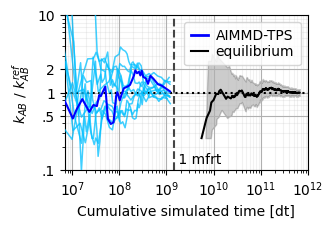

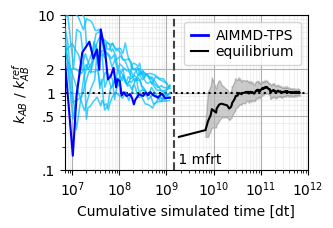

In [50]:
# kAB plot
initialize_plot()

# AIMMD estimates
for i in range(11, 20):
    plt.plot(times[i], kAB[i] / kAB0[-1],
             color=AIMMD_TPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[10], kAB[10] / kAB0[-1],
         color=AIMMD_TPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# equilibrium reference estimates
plt.plot(0,0, lw=2, color=AIMMD_TPS_front_color, label='AIMMD')
plt.fill_between(times0[3::2], kAB0_min[3::2]/kAB0[-1],
                 kAB0_max[3::2]/kAB0[-1], alpha=.2,
                 color='black')
plt.plot(times0[::2], kAB0[::2]/kAB0[-1],
         color=EQ_color, label='equilibrium')


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.grid(which='minor', alpha=.167)
plt.legend(labelspacing=.1,
           borderpad=.5,
           handletextpad=.5,
           handlelength=1.25,
          loc='upper right')

ax = plt.gca()
ax.margins(0.025)
plt.xlim(7e6, 1e12)
xlim = ax.get_xlim()
ax.axhline(1., color='black', linestyle=':', zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(.1, 10)
plt.ylim(.1, 10)
ax.set_yticks([.1,.5, 1, 2, 10],['.1', '.5', '1', '2', '10'])
plt.xlabel('Cumulative simulated time [dt]')
plt.ylabel('$k_{AB}~/~k_{AB}^{ref}$')
plt.axvline(mfrt, linestyle='--', color='#444444', zorder=2)
plt.text(mfrt, .12, ' 1 mfrt', ha='left')
plt.savefig(f'figures/{name}_kAB_tps.pdf')

# kBA plot
initialize_plot()

# AIMMD estimates
for i in range(11, 20):
    plt.plot(times[i], kBA[i] / kBA0[-1],
             color=AIMMD_TPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[10], kBA[10] / kBA0[-1],
         color=AIMMD_TPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# equilibrium reference estimates
plt.plot(0,0, lw=2, color=AIMMD_TPS_front_color, label='AIMMD')
plt.fill_between(times0[3::2], kBA0_min[3::2]/kBA0[-1],
                 kBA0_max[3::2]/kBA0[-1], alpha=.2,
                 color='black')
plt.plot(times0[1::2], kBA0[1::2]/kBA0[-1],
         color=EQ_color, label='equilibrium')


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.grid(which='minor', alpha=.167)
plt.legend(labelspacing=.1,
           borderpad=.5,
           handletextpad=.5,
           handlelength=1.25,
          loc='upper right')

ax = plt.gca()
ax.margins(0.025)
plt.xlim(7e6, 1e12)
xlim = ax.get_xlim()
ax.axhline(1., color='black', linestyle=':', zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(.1, 10)
plt.ylim(.1, 10)
ax.set_yticks([.1,.5, 1, 2, 10],['.1', '.5', '1', '2', '10'])
plt.xlabel('Cumulative simulated time [dt]')
plt.ylabel('$k_{AB}~/~k_{AB}^{ref}$')
plt.axvline(mfrt, linestyle='--', color='#444444', zorder=2)
plt.text(mfrt, .12, ' 1 mfrt', ha='left')
plt.savefig(f'figures/{name}_kBA_tps.pdf')

### Plot error at TS

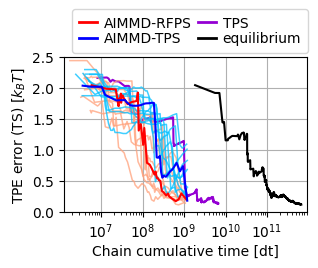

In [51]:
initialize_plot()

# RFPS-AIMMD
for i in range(1, 10):
    plt.plot(times[i], TS_error[i],
             color=AIMMD_RFPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[0], TS_error[0],
         color=AIMMD_RFPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# AIMMD (TPS)
for i in range(11, 20):
    plt.plot(times[i], TS_error[i],
             color=AIMMD_TPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[10], TS_error[10],
         color=AIMMD_TPS_front_color, lw=1.5,
         zorder=20, alpha=1)

plt.plot(times0[1:], TS_error0[1:], color=EQ_color)
plt.plot(tps.completion_times, tps_TS_error, color=TPS_color)

plt.gca().set_xscale('log')
plt.grid()
ax = plt.gca()
ax.margins(0.025)
plt.ylim(0, 2.5)
plt.plot(0,0, lw=2, color='red', label='RFPS-AIMMD')
plt.plot(0,0, lw=2, color='blue', label='AIMMD')
plt.plot(0,0, lw=2, color='darkviolet', label='TPS')
plt.plot(0,0, lw=2, color='black', label='equilibrium')

plt.legend(labelspacing=.1,
           columnspacing=0.5,
           borderpad=.5,
           handletextpad=.5,
           handlelength=1.25, ncol=2, loc=(0.034,1.03))

plt.xlabel('Chain cumulative time [dt]', labelpad=2.5)
plt.ylabel('TPE error (TS) [$k_BT$]')
plt.savefig(f'figures/{name}_tpe_error_ts.pdf')

# Chignolin

In [2]:
# main parameters
system = '../data/chignolin'
name = system.split('/')[-1]

# integrator
dt = 1e-4  # interval between frames [us]
nsteps_ceil = 250

# plotting parameters
potential_energy_levels = np.arange(0, 11, 1)

# tool for processing trajectory file (make molecules whole)
def process_trajectory_file(fname,
    topology=f'{system}/run.gro', out='temp.xtc'):
    trajectory = md.load(f'{fname}',top=topology)
    atom = [atom for atom in trajectory.topology.atoms]
    for i in range(1,166):
        trajectory.topology.add_bond(atom[0], atom[i])
    trajectory.make_molecules_whole()
    trajectory.save(out)

# CV representation definition
d1 = [55, 101]  # 3-7 interatomic distance indices
d2 = [25, 119]  # 2-8 interatomic distance indices

# grid and CG grid
x = np.arange(0.25, 1.025, .025)
y = np.linspace(0.25, 1.55, len(x))
X, Y = np.meshgrid((x[1:] + x[:-1]) / 2, (y[1:] + y[:-1]) / 2)
x2 = x[::4]
y2 = y[::4]
X2, Y2 = np.meshgrid((x2[1:] + x2[:-1]) / 2, (y2[1:] + y2[:-1]) / 2)

# CV function
distance_cv = lambda trajectory: md.compute_distances(trajectory, [d1, d2])

# project pathensemble onto cv (multiple weights at once)
def project(pathensemble, Bins=[[x, y]],
            cv=distance_cv, dim=2,
            top=f'{system}/run.gro',
            Weights = [None]):
    
    values = np.zeros((len(pathensemble.frame_values), dim))
    
    # (re)compute CV for all paths
    # it is faster but works only in special cases (order)
    for i, filename in tqdm(
        enumerate(pathensemble.trajectory_files), position=0,
        total=len(pathensemble.trajectory_files)):
        if hasattr(pathensemble, 'directory'):
            filename = f'{pathensemble.directory}/{filename}'
        n = np.sum(pathensemble.frame_trajectory_indices == i)
        values[pathensemble.frame_trajectory_indices == i] = cv(
            md.load(filename, top=top)[:n])
    
    # extract frames and weights
    results = []
    for weights, bins in zip(Weights, Bins):
        if weights is None:
            weights = pathensemble.weights
        frame_weights = np.zeros(pathensemble.nframes)
        path_indices = np.arange(len(pathensemble))[None].ravel()
        for frame_indices, weight in zip(
            pathensemble.frame_indices(None, internal=True), weights):
            frame_weights[frame_indices] += weight
        frame_indices = np.where(frame_weights > 0)[0]
        w = frame_weights[frame_indices]  # now weights of frames
        v = values[frame_indices]
        results.append(np.histogramdd(
            v, bins, density=False, weights=w)[0].T)

    return results

## Load equilibrium simulations

Attention! Running this cell takes a while (> 10 mins).

In [3]:
# assign to equilibrium simulations path ensemble...
# ...the same params for states definition and NN model as fps0
cwd = os.getcwd()
os.chdir(f'{system}/fps0')
exec(open(f'params.py', 'r').read())
os.chdir(cwd)

# load results as "reference equilibrium path ensemble"
reference_pe = PathEnsemble(
    f'{system}/equilibrium', '../mol.pdb',
    states_function, descriptors_function, values_function)
for i in tqdm(range(4), position=0):
    reference_pe.add_path(f'run{i}.xtc')
reference_pe.split()

# estimate transition rates
(kAB0, kBA0, kAB0_max, kBA0_max, kAB0_min, kBA0_min,
 TP_length, TP_length_max, TP_length_min, times0) = (
    estimate_transition_rates_from_equilibrium(reference_pe))

# convert to the right units
kAB0 *= 1e6  # 1/us
kBA0 *= 1e6
kAB0_max *= 1e6
kBA0_max *= 1e6
kAB0_min *= 1e6
kBA0_min *= 1e6
TP_length *= dt  # us
TP_length_max *= dt
TP_length_min *= dt
times0 /= 1e6  # us
dkAB0 = (kAB0_max - kAB0_min) / 4
dkBA0 = (kBA0_max - kBA0_min) / 4

print('Transition rates from a long equilibrium simulation')
print(f'{kAB0[-1]:.3e} +- {100*dkAB0[-1]/kAB0[-1]:.2f}% '
      f'out of {len(kAB0) // 2} events')
print(f'{kBA0[-1]:.3e} +- {100*dkBA0[-1]/kBA0[-1]:.2f}% '
      f'out of {len(kAB0) // 2} events')

mfrt = 1 / kAB0[-1] + 1 / kBA0[-1]
print(f'Mean first return time: {mfrt:.3e} [dt]')

ResUnit 1 is 710 units wide.
Dropout before it is 0.10331879113280755.
ResUnit 2 is 244 units wide.
Dropout before it is 0.035582575337149036.
ResUnit 3 is 84 units wide.
Dropout before it is 0.012254495564087635.
ResUnit 4 is 29 units wide.
Dropout before it is 0.004220398892079623.
ResUnit 5 is 10 units wide.
Dropout before it is 0.0014534883720930232.


100%|██████████| 4/4 [11:28<00:00, 172.23s/it]


Transition rates from a long equilibrium simulation
2.841e-01 +- 19.55% out of 29 events
2.525e+00 +- 20.32% out of 29 events
Mean first return time: 3.916e+00 [dt]


## Prepare validation data

In [4]:
# pB model validation: load the validation SPs in the same path ensemble
validation = PathEnsemble(f'{system}/validation', '../run.gro', states_function,
    descriptors_function, values_function)
validation.append('validation.xtc')
validated_committor = np.load(f'{system}/validation/validation.npy')

# compute binomial statistics for true vs estimated committor plot
from scipy.special import binom
from scipy.integrate import quad

f = lambda q, m, n: binom(n, m) * q ** m * (1 - q) ** (n - m)

z_min = []
z_max = []

for i in tqdm(np.linspace(0, 1, 21)):
    i = int(i * 20)
    quantile = .025
    
    # right side
    z = i / 20
    while quad(lambda x: f(x,i,20), z, 1)[0] / quad(
               lambda x: f(x,i,20), 0, 1)[0] > .025 and z <= .9999:
        z += .0001
    if z == 1:
        quantile = .05
    
    # left size
    z = i / 20
    while quad(lambda x: f(x,i,20), 0, z)[0] / quad(
               lambda x: f(x,i,20), 0, 1)[0] > quantile and z >= .0001:
        z -= .0001
    if z == 0:
        quantile = .05
    z_min.append(z)
    
    # right side again with right quantile
    z = i / 20
    while quad(lambda x: f(x,i,20), z, 1)[0] / quad(
               lambda x: f(x,i,20), 0, 1)[0] > quantile and z <= .9999:
        z += .0001
    z_max.append(z)

<string>:25: RuntimeWarning: overflow encountered in exp
100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


## System presentation

100%|██████████| 4/4 [00:57<00:00, 14.45s/it]
/tmp/ipykernel_3513000/3662405700.py:12: RuntimeWarning: divide by zero encountered in log
  F = -np.log(P0)
/tmp/ipykernel_3513000/3662405700.py:22: RuntimeWarning: invalid value encountered in divide
  c = plt.contour(X2, Y2, PB/P2, levels=[.1, .5, .9], colors='white', zorder=12)


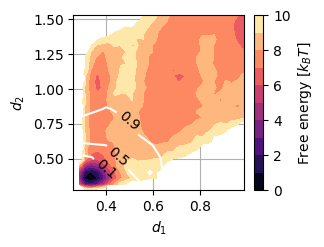

In [5]:
# project reference PE and TPE on CVs
reference_pe.weights = 1.
wT = reference_pe.are_transitions
wB = ((reference_pe.initial_states == 'B') + 
      (reference_pe.internal_states == 'B'))
P0, TP0, P2, PB = project(reference_pe,
        top = f'{system}/mol.pdb',
        Bins = [[x, y], [x, y], [x2, y2], [x2, y2]],
        Weights = [None, wT, None, wB])
P0 /= np.sum(P0)
TP0 /= np.sum(TP0)
F = -np.log(P0)
F -= np.min(F)

# plot free energy
figure, ax = initialize_plot()
plt.contourf(X, Y, F, zorder=2, levels=potential_energy_levels,
             cmap='magma')
plt.colorbar(label='Free energy $[k_BT]$')

# plot effective committor (coarse grid)
c = plt.contour(X2, Y2, PB/P2, levels=[.1, .5, .9], colors='white', zorder=12)
plt.clabel(c, colors='black')

plt.grid()
plt.xlabel('$d_1$')
plt.ylabel('$d_2$')
figure.subplots_adjust(left=.2,bottom=.22,right=.91,top=.92,hspace=0)

plt.savefig(f'figures/{name}_2d_reference.pdf')

## Trajectory time series

Compare two committor models over a reference transition.

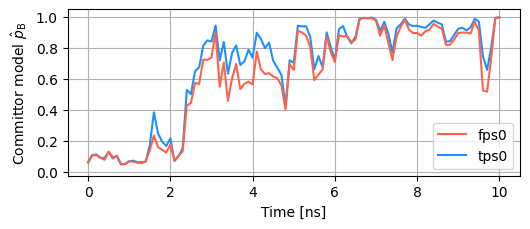

In [6]:
plt.figure(figsize=(5.4,2.4))
network_parameters = f'{system}/fps0/network000250.h5'
network.load_state_dict(
    torch.load(network_parameters, map_location=device))

d = reference_pe.descriptors(np.where(
    reference_pe.are_transitions)[0][4])[0]
t = np.arange(len(d)) * .1
plt.plot(t, expit(evaluate(network, d)), color=AIMMD_RFPS_color,
         zorder=5, label='fps0')

network_parameters = f'{system}/tps0/network000250.h5'
network.load_state_dict(
    torch.load(network_parameters, map_location=device))

plt.plot(t, expit(evaluate(network, d)), color=AIMMD_TPS_color,
         label='tps0')
plt.legend(loc='lower right')

plt.grid()
plt.ylim(-.025,1.05)
plt.xlabel('Time [ns]')
plt.ylabel('Committor model $\hat p_{\mathrm{B}}$')
plt.tight_layout()
plt.savefig(f'figures/{name}_pB_time_series.pdf')

## Load and analyze AIMMD results (fixed budget)

Run the following cells for all directories and computational budgets to obtain the related figures in main text and Supplental Material of the paper.

In [96]:
directory = 'fps0'
budget = 4  # us

if 'fps' in directory:
    base_color = AIMMD_RFPS_color
else:
    base_color = AIMMD_TPS_color

# load params settings (NN architecture, states definition,
#                       reweight parameters, etc.)
cwd = os.getcwd()
os.chdir(f'{system}/{directory}')
exec(open(f'params.py', 'r').read())
os.chdir(cwd)

# update reference path ensembles settings
reference_pe.states_function = states_function
reference_pe.descriptors_function = descriptors_function
reference_pe.values_function = values_function

# load all simulations in PathEnsemble objects
print(f'loading AIMMD {directory} run')
Pathensemble = load_pathensemble(
    states_function, descriptors_function, values_function,
    directory=f'{system}/{directory}')
Shots, EquilibriumA, EquilibriumB = scorporate_pathensembles(Pathensemble)

# exclude simulations after computational budget
completion_times = np.sort(Pathensemble.frame_simulation_times)
tmax = completion_times[min(int(budget / dt), len(completion_times) - 1)]
tmax = min(tmax, Shots.completion_times[-1])
step_number = int(min(np.ceil(np.sum(
    Shots.completion_times <= tmax)), nsteps_ceil))
print(f'\ncomputational budget: {budget:.3e} [dt] ({budget/mfrt:.3f} mfrt)')
pathensemble = crop_pathensemble(Pathensemble, step_number)
shots, equilibriumA, equilibriumB = scorporate_pathensembles(pathensemble)

# retrieve the NN model at the time of the computational budget
network = Network().to(device)
try:
    network.load_state_dict(torch.load(
        f'{system}/{directory}/network{step_number:06g}.h5',
        map_location=device))
except:  # retrain on the available data if the parameters are not present
    network, *_ = fit(Network(), pathensemble, verbose=True)

# update pathensembles CV values
pathensemble.update_values()
reference_pe.update_values()

# get SP selection bins
bins = get_bins(pathensemble, n_bins)

# reweight
(wA, path_indicesA, internal_segmentsA, excursionsA,
 xPA, mA, extremesA, shooting_valuesA, factorsA) = pathensemble.reweight(
     'A', **reweight_parameters)
(wB, path_indicesB, internal_segmentsB, excursionsB,
 xPB, mB, extremesB, shooting_valuesB, factorsB) = pathensemble.reweight(
     'B', **reweight_parameters)

# estimate transition rates
pathensemble.weights = wA
kAB = 1 / (pathensemble.project()[0] * dt)
pathensemble.weights = wB
kBA = 1 / (pathensemble.project()[0] * dt)

# report
print(f'Step {step_number:5}: '
      f'nT = {np.sum(shots.are_transitions):<5.0f} '
      f'kAB = {kAB:.2e} (/ref = {kAB/kAB0[-1]:.2e}), '
      f'kBA = {kBA:.2e} (/ref = {kBA/kBA0[-1]:.2e})')

# accepted moves
if 'tps' in directory:
    print('accepted moves: ', np.sum(np.load(
        f'{system}/{directory}/shots0/chain_weights.npy')[:step_number] > 0))

ResUnit 1 is 710 units wide.
Dropout before it is 0.10331879113280755.
ResUnit 2 is 244 units wide.
Dropout before it is 0.035582575337149036.
ResUnit 3 is 84 units wide.
Dropout before it is 0.012254495564087635.
ResUnit 4 is 29 units wide.
Dropout before it is 0.004220398892079623.
ResUnit 5 is 10 units wide.
Dropout before it is 0.0014534883720930232.
loading AIMMD fps0 run
shots: Union of 1 non-empty PathEnsemble instances, 251 paths from 251 trajectory files, 38181 individual frames
    chain 0: 251 paths, 55 transitions, last updated 5581967 s ago
equilibriumA: Union of 2 non-empty PathEnsemble instances, 8478 paths from 239 trajectory files, 37137 individual frames
equilibriumB: Union of 11 non-empty PathEnsemble instances, 5096 paths from 254 trajectory files, 37550 individual frames

computational budget: 4.000e+00 [dt] (1.021 mfrt)
Step    90: nT = 20    kAB = 5.25e-01 (/ref = 1.85e+00), kBA = 3.60e+00 (/ref = 1.42e+00)


### 1D free energy projection

/home/lazzeri/projects/aimmd/analysis/../data/wq/utils.py:1858: RuntimeWarning: divide by zero encountered in log
  F0 = -np.log(result)
/home/lazzeri/projects/aimmd/analysis/../data/wq/utils.py:1879: RuntimeWarning: divide by zero encountered in log
  F = -np.log(result)


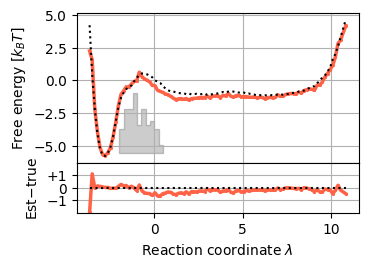

In [97]:
pathensemble.weights = wA + wB
figure, axes = plot_1d_energy_profile(pathensemble,
                                      reference_pe,
                                      nbins=101,
                                      vmin=-np.inf,
                                      vmax=+np.inf,
                                      pathensemble_bootstrapping=0,
                                      reference_bootstrapping=0,
                                      reweight_parameters=reweight_parameters,
                                      offset=0,
                                      max_error=2.,
                                      base_color=base_color,
                                      SP_selection_bins=bins)
plt.savefig(f'figures/{name}_{directory}_{len(shots)}_free.pdf')

### 2D free energy projection (difference)

Attention! **You need the trajectory files from the supplemental repositories for this**. Running this cell may take a while (> 10 min).

100%|██████████| 267/267 [07:11<00:00,  1.62s/it]
/tmp/ipykernel_3513000/1163831676.py:6: RuntimeWarning: divide by zero encountered in log
  F = -np.log(P)
/tmp/ipykernel_3513000/1163831676.py:7: RuntimeWarning: divide by zero encountered in log
  F0 = -np.log(P0)
/tmp/ipykernel_3513000/1163831676.py:11: RuntimeWarning: invalid value encountered in subtract
  plt.contourf(X, Y, F-F0, zorder=2, levels=np.arange(-2, 2.5, .5))
/tmp/ipykernel_3513000/1163831676.py:15: RuntimeWarning: invalid value encountered in divide
  c = plt.contour(X2, Y2, PB/P2, levels=[.1, .5, .9], colors='white', zorder=12)


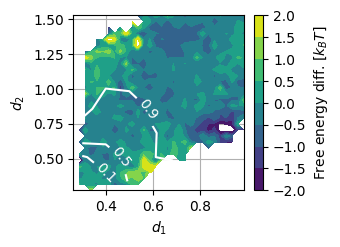

In [98]:
# project reference PE on CVs
P, P2, PB = project(pathensemble,
        Bins = [[x, y], [x2, y2], [x2, y2]],
        Weights = [wA + wB, wA + wB, wB])
P /= np.sum(P)
F = -np.log(P)
F0 = -np.log(P0)

# plot free energy
figure, ax = initialize_plot()
plt.contourf(X, Y, F-F0, zorder=2, levels=np.arange(-2, 2.5, .5))
plt.colorbar(label='Free energy diff. $[k_BT]$')

# plot effective committor (coarse grid)
c = plt.contour(X2, Y2, PB/P2, levels=[.1, .5, .9], colors='white', zorder=12)
plt.clabel(c, colors='white')

plt.grid()
plt.xlabel('$d_1$')
plt.ylabel('$d_2$')
figure.subplots_adjust(left=.2,bottom=.22,right=.91,top=.92,hspace=0)

plt.savefig(f'figures/{name}_{directory}_{len(shots)}_2d_diff.pdf')

### 2D TPE projection (difference)

Attention! Running this cell may take a while (> 5 min).

100%|██████████| 28/28 [00:09<00:00,  2.81it/s]
/tmp/ipykernel_3513000/2466646853.py:13: RuntimeWarning: divide by zero encountered in log
  F = -np.log(P)
/tmp/ipykernel_3513000/2466646853.py:14: RuntimeWarning: divide by zero encountered in log
  F0 = -np.log(TP0)
/tmp/ipykernel_3513000/2466646853.py:18: RuntimeWarning: invalid value encountered in subtract
  plt.contourf(X, Y, F-F0, zorder=2, levels=np.arange(-2, 2.5, .5))
/tmp/ipykernel_3513000/2466646853.py:22: RuntimeWarning: invalid value encountered in divide
  c = plt.contour(X2, Y2, PB/P2, levels=[.1, .5, .9], colors='white', zorder=12)


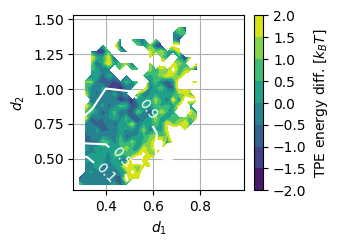

In [99]:
# retrieve transitions with correct weights
if 'fps' in directory:
    pathensemble.weights = (wA + wB) * pathensemble.are_transitions
else:
    pathensemble.weights = 0.
    shots.weights = np.load(f'{system}/{directory}/shots0/chain_weights.npy')

transitions = pathensemble[pathensemble.are_transitions]  # faster

# project reference PE on CVs
P = project(transitions, Bins = [[x, y]])[0]
P /= np.sum(P)
F = -np.log(P)
F0 = -np.log(TP0)

# plot free energy
figure, ax = initialize_plot()
plt.contourf(X, Y, F-F0, zorder=2, levels=np.arange(-2, 2.5, .5))
plt.colorbar(label='TPE energy diff. $[k_BT]$')

# plot effective committor (coarse grid)
c = plt.contour(X2, Y2, PB/P2, levels=[.1, .5, .9], colors='white', zorder=12)
plt.clabel(c, colors='white')

plt.grid()
plt.xlabel('$d_1$')
plt.ylabel('$d_2$')
figure.subplots_adjust(left=.2,bottom=.22,right=.91,top=.92,hspace=0)

plt.savefig(f'figures/{name}_{directory}_{len(shots)}_tpe_2d_diff.pdf')

### Committor model error

0.00 -> 0.097, 0.071
0.05 -> 0.070, 0.012
0.10 -> 0.336, 0.000
0.20 -> 0.516, 0.160
0.25 -> 0.390, 0.218
0.40 -> 0.574, 0.127
0.45 -> 0.525, 0.111
0.50 -> 0.533, 0.079
0.55 -> 0.505, 0.060
0.65 -> 0.484, 0.173
0.75 -> 0.526, 0.154
0.80 -> 0.821, 0.134
0.90 -> 0.861, 0.090
1.00 -> 0.954, 0.073

Committor model WRMSE: 0.155


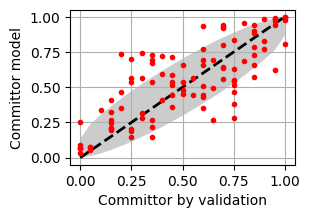

In [100]:
validation.update_values()
estimated_committor = expit(validation.frame_values)

# forall values mean and standard deviation
for i in np.linspace(0, 1, 21):
    k = np.where(validated_committor == i)[0]
    if not np.sum(k): continue
    print(f'{i:.2f} -> {np.mean(estimated_committor[k]):.3f}, '
          f'{np.std(estimated_committor[k]):.3f}')
print()

wrmse = np.average(
    (validated_committor - estimated_committor) ** 2,
     weights = 1/(validated_committor * (1-validated_committor)+.025)) ** .5
print(f'Committor model WRMSE: {wrmse:.3f}')

initialize_plot()
plt.plot(validated_committor, estimated_committor, '.', 
         zorder=5, color='red' if 'fps' in directory else 'blue',
         markersize=6,
        alpha=1)
plt.plot([0,1],[0,1], '--', color='black', lw=2, zorder=3)
plt.fill_between(np.linspace(0, 1, 21), z_min, z_max, fc='black', alpha=.2)
plt.grid()
plt.xlabel('Committor by validation')
plt.ylabel('Committor model')
plt.subplots_adjust(left=0.24, bottom=0.18, right=0.99, top=0.8)
plt.savefig(f'figures/{name}_{directory}_{step_number}_validation.pdf')

## All 1D free energies together

### Defining bins and model

In [93]:
# params
network_model = f'{system}/fps0/network000090.h5'
budget = 4  # us

# model
network = Network().to(device)
network.load_state_dict(torch.load(network_model, map_location=device))
reference_pe.frame_values = evaluate(network, reference_pe.frame_descriptors)

# bins
vmin = np.max([-30, np.min(np.concatenate(reference_pe.values(reference_pe.weights > 0)))])
vmax = np.min([+30, np.max(np.concatenate(reference_pe.values(reference_pe.weights > 0)))])
bins = np.linspace(vmin, vmax, 101 + 1)
A = (bins[:-1] + bins[1:]) / 2
print(f'vmin: {vmin:.3f}, vmax: {vmax:.3f}')

# reference free energy
p0 = reference_pe.project(bins)
p0 /= np.sum(p0)
f0 = -np.log(p0)
offset = -f0[np.argmin(np.abs(A))]
f0 += offset

vmin: -3.746, vmax: 11.204


/tmp/ipykernel_3513000/3705726317.py:20: RuntimeWarning: divide by zero encountered in log
  f0 = -np.log(p0)


### Computation

In [94]:
directories = [f'fps{i}' for i in range(3)] + [
               f'tps{i}' for i in range(3)]
profiles = []

for directory in directories:
    # load params settings (NN architecture, states definition,
    #                       reweight parameters, etc.)
    cwd = os.getcwd()
    os.chdir(f'{system}/{directory}')
    exec(open(f'params.py', 'r').read())
    os.chdir(cwd)
    
    # load all simulations in PathEnsemble objects
    print(f'loading AIMMD {directory} run')
    Pathensemble = load_pathensemble(
        states_function, descriptors_function, values_function,
        directory=f'{system}/{directory}')
    Shots, EquilibriumA, EquilibriumB = scorporate_pathensembles(Pathensemble)
    print()
    
    # exclude simulations after computational budget
    completion_times = np.sort(Pathensemble.frame_simulation_times)
    tmax = completion_times[min(int(budget / dt), len(completion_times) - 1)]
    tmax = min(tmax, Shots.completion_times[-1])
    step_number = int(min(np.ceil(np.sum(
        Shots.completion_times <= tmax)), nsteps_ceil))
    pathensemble = crop_pathensemble(Pathensemble, step_number)
    shots, equilibriumA, equilibriumB = scorporate_pathensembles(pathensemble)
    
    # retrieve the NN model at the time of the computational budget
    network = Network().to(device)
    try:
        network.load_state_dict(torch.load(
            f'{system}/{directory}/network{step_number:06g}.h5',
            map_location=device))
    except:  # retrain on the available data if the parameters are not present
        network, *_ = fit(Network(), pathensemble, verbose=True)
    
    # update pathensemble CV values
    pathensemble.update_values()
    
    # reweight
    (wA, path_indicesA, internal_segmentsA, excursionsA,
     xPA, mA, extremesA, shooting_valuesA, factorsA) = pathensemble.reweight(
         'A', **reweight_parameters)
    (wB, path_indicesB, internal_segmentsB, excursionsB,
     xPB, mB, extremesB, shooting_valuesB, factorsB) = pathensemble.reweight(
         'B', **reweight_parameters)
    
    # back to reference model
    network = Network().to(device)
    network.load_state_dict(
        torch.load(network_model, map_location=device))
    pathensemble.update_values()
    
    # do projection
    pathensemble.weights = wA + wB
    profiles.append(pathensemble.project(bins))

ResUnit 1 is 710 units wide.
Dropout before it is 0.10331879113280755.
ResUnit 2 is 244 units wide.
Dropout before it is 0.035582575337149036.
ResUnit 3 is 84 units wide.
Dropout before it is 0.012254495564087635.
ResUnit 4 is 29 units wide.
Dropout before it is 0.004220398892079623.
ResUnit 5 is 10 units wide.
Dropout before it is 0.0014534883720930232.
loading AIMMD fps0 run
shots: Union of 1 non-empty PathEnsemble instances, 251 paths from 251 trajectory files, 38181 individual frames
    chain 0: 251 paths, 55 transitions, last updated 5581932 s ago
equilibriumA: Union of 2 non-empty PathEnsemble instances, 8478 paths from 239 trajectory files, 37137 individual frames
equilibriumB: Union of 11 non-empty PathEnsemble instances, 5096 paths from 254 trajectory files, 37550 individual frames

ResUnit 1 is 710 units wide.
Dropout before it is 0.10331879113280755.
ResUnit 2 is 244 units wide.
Dropout before it is 0.035582575337149036.
ResUnit 3 is 84 units wide.
Dropout before it is 0.01

### Plot results

/tmp/ipykernel_3513000/3977109569.py:7: RuntimeWarning: divide by zero encountered in log
  f = -np.log(profiles[i] / np.sum(profiles[i])) + offset
/tmp/ipykernel_3513000/3977109569.py:11: RuntimeWarning: invalid value encountered in subtract
  ax2.plot(A, f-f0,
/tmp/ipykernel_3513000/3977109569.py:14: RuntimeWarning: divide by zero encountered in log
  f = -np.log(profiles[3] / np.sum(profiles[3])) + offset
/tmp/ipykernel_3513000/3977109569.py:18: RuntimeWarning: invalid value encountered in subtract
  ax2.plot(A, f-f0,
/tmp/ipykernel_3513000/3977109569.py:23: RuntimeWarning: divide by zero encountered in log
  f = -np.log(profiles[i] / np.sum(profiles[i])) + offset
/tmp/ipykernel_3513000/3977109569.py:27: RuntimeWarning: invalid value encountered in subtract
  ax2.plot(A, f-f0,
/tmp/ipykernel_3513000/3977109569.py:30: RuntimeWarning: divide by zero encountered in log
  f = -np.log(profiles[0] / np.sum(profiles[0])) + offset
/tmp/ipykernel_3513000/3977109569.py:34: RuntimeWarning: inv

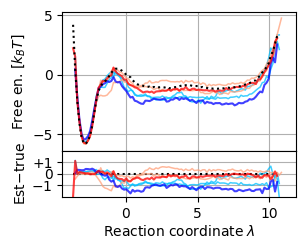

In [95]:
figure, (ax1, ax2) = plt.subplots(2,1,
                                      figsize=(3,2.5),
                                      sharex=True,
                                      gridspec_kw={'height_ratios': [3, 1]})

for i in range(4, 6):
    f = -np.log(profiles[i] / np.sum(profiles[i])) + offset
    ax1.plot(A, f,
             color=AIMMD_TPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
    ax2.plot(A, f-f0,
             color=AIMMD_TPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
f = -np.log(profiles[3] / np.sum(profiles[3])) + offset
ax1.plot(A, f,
         color=AIMMD_TPS_front_color, lw=1.5,
         zorder=20, alpha=.75)
ax2.plot(A, f-f0,
         color=AIMMD_TPS_front_color, lw=1.5,
         zorder=20, alpha=.75)

for i in range(1, 3):
    f = -np.log(profiles[i] / np.sum(profiles[i])) + offset
    ax1.plot(A, f,
             color=AIMMD_RFPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
    ax2.plot(A, f-f0,
             color=AIMMD_RFPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
f = -np.log(profiles[0] / np.sum(profiles[0])) + offset
ax1.plot(A, f,
         color=AIMMD_RFPS_front_color, lw=1.5,
         zorder=20, alpha=.75)
ax2.plot(A, f-f0,
         color=AIMMD_RFPS_front_color, lw=1.5,
         zorder=20, alpha=.75)

f0[np.isinf(f)] = np.nan
ax1.plot(A, f0, ':', color='black', zorder=30)
ax2.plot(A, f0*0., ':', color='black')

ax2.set_ylim(-2,2)
ax1.grid()
ax2.grid()
plt.minorticks_off()
ax2.set_xlabel('Reaction coordinate $\lambda$', labelpad=2.5)
ax1.set_ylabel('Free en. [$k_BT$]')
ax2.set_ylabel('Est$-$true', labelpad=2.5)
plt.subplots_adjust(left=0.2105, bottom=0.16, right=0.99,
                    top=0.9, hspace=0)

ylim = ax1.get_ylim()
ax2.set_yticks([-1, 0., 1], ['$-$1','0','+1'])
plt.savefig(
    f'figures/{name}_{network_model.split("/")[-1]}_budget_{budget/mfrt}_1d.pdf')

## Rates estimates and committor error evolution

### Compute estimates of the AIMMD runs

In [87]:
directories = [f'fps{i}' for i in range(3)] + [
               f'tps{i}' for i in range(3)]
budgets = np.array([.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5,
                    5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                    16, 17, 18, 19, 20])  # us

kAB = []
kBA = []
times = []
pB_error = []

for directory in directories:

    # initialize empty time and estimate lists
    times.append([])
    kAB.append([])
    kBA.append([])
    pB_error.append([])
    
    # load params settings (NN architecture, states definition,
    #                       reweight parameters, etc.)
    cwd = os.getcwd()
    os.chdir(f'{system}/{directory}')
    exec(open(f'params.py', 'r').read())
    os.chdir(cwd)
    
    # load all simulations in PathEnsemble objects
    print(f'loading AIMMD {directory} run')
    Pathensemble = load_pathensemble(
        states_function, descriptors_function, values_function,
        directory=f'{system}/{directory}')
    Shots, EquilibriumA, EquilibriumB = scorporate_pathensembles(Pathensemble)
    print()
    
    for budget in budgets:
        
        # exclude simulations after computational budget
        completion_times = np.sort(Pathensemble.frame_simulation_times)
        tmax = completion_times[min(int(budget / dt), len(completion_times) - 1)]
        tmax = min(tmax, Shots.completion_times[-1])
        step_number = int(min(np.ceil(np.sum(
            Shots.completion_times <= tmax)), nsteps_ceil))
        print(f'\ncomputational budget: {budget:.3e} [dt] ({budget/mfrt:.3f} mfrt)')
        pathensemble = crop_pathensemble(Pathensemble, step_number)
        shots, equilibriumA, equilibriumB = scorporate_pathensembles(pathensemble)
        
        t = np.sum(pathensemble.internal_lengths) * dt
        if len(times[-1]) and times[-1][-1] == t:
            # already done with the estimates: no use in redoing it
            times[-1].append(times[-1][-1])
            kAB[-1].append(kAB[-1][-1])
            kBA[-1].append(kBA[-1][-1])
            pB_error[-1].append(pB_error[-1][-1])
            continue
        
        # retrieve the NN model at the time of the computational budget
        network = Network().to(device)
        try:
            network.load_state_dict(torch.load(
                f'{system}/{directory}/network{step_number:06g}.h5',
                map_location=device))
        except:  # retrain on the available data if the parameters are not present
            network, *_ = fit(Network(), pathensemble, verbose=True)
        
        # update pathensemble CV values
        pathensemble.update_values()
        
        # reweight
        (wA, path_indicesA, internal_segmentsA, excursionsA,
         xPA, mA, extremesA, shooting_valuesA, factorsA) = pathensemble.reweight(
             'A', **reweight_parameters)
        (wB, path_indicesB, internal_segmentsB, excursionsB,
         xPB, mB, extremesB, shooting_valuesB, factorsB) = pathensemble.reweight(
             'B', **reweight_parameters)
        
        # estimate transition rates
        pathensemble.weights = wA
        kAB[-1].append(1 / (pathensemble.project()[0] * dt))
        pathensemble.weights = wB
        kBA[-1].append(1 / (pathensemble.project()[0] * dt))
        times[-1].append(np.sum(pathensemble.internal_lengths) * dt)
        
        # report
        print(f'Step {step_number:5}: '
              f'nT = {np.sum(shots.are_transitions):<5.0f} '
              f'kAB = {kAB[-1][-1]:.2e} (/ref = {kAB[-1][-1]/kAB0[-1]:.2e}), '
              f'kBA = {kBA[-1][-1]:.2e} (/ref = {kBA[-1][-1]/kBA0[-1]:.2e})')
        
        # accepted moves
        if 'tps' in directory:
            print('accepted moves: ', np.sum(np.load(
                f'{system}/{directory}/shots0/chain_weights.npy')[:step_number] > 0))
        
        # pB error
        validation.update_values()
        estimated_committor = expit(validation.frame_values)
        pB_error[-1].append(np.average(
            (validated_committor - estimated_committor) ** 2,
             weights = 1/(validated_committor *
                          (1 - validated_committor)+.025)) ** .5)
        print(f'Committor model WRMSE: {pB_error[-1][-1]:.3f}')

times = np.array(times)
kAB = np.array(kAB)
kBA = np.array(kBA)
pB_error = np.array(pB_error)

ResUnit 1 is 710 units wide.
Dropout before it is 0.10331879113280755.
ResUnit 2 is 244 units wide.
Dropout before it is 0.035582575337149036.
ResUnit 3 is 84 units wide.
Dropout before it is 0.012254495564087635.
ResUnit 4 is 29 units wide.
Dropout before it is 0.004220398892079623.
ResUnit 5 is 10 units wide.
Dropout before it is 0.0014534883720930232.
loading AIMMD fps0 run
shots: Union of 1 non-empty PathEnsemble instances, 251 paths from 251 trajectory files, 38181 individual frames
    chain 0: 251 paths, 55 transitions, last updated 5580524 s ago
equilibriumA: Union of 2 non-empty PathEnsemble instances, 8478 paths from 239 trajectory files, 37137 individual frames
equilibriumB: Union of 11 non-empty PathEnsemble instances, 5096 paths from 254 trajectory files, 37550 individual frames


computational budget: 5.000e-01 [dt] (0.128 mfrt)
Step    12: nT = 3     kAB = 2.41e+00 (/ref = 8.50e+00), kBA = 5.31e+00 (/ref = 2.10e+00)
Committor model WRMSE: 0.187

computational budget: 1.0

100%|██████████| 100/100 [00:04<00:00, 21.15it/s]


Training took 8.6s
Step   241: nT = 71    kAB = 3.86e-01 (/ref = 1.36e+00), kBA = 2.80e+00 (/ref = 1.11e+00)
accepted moves:  48
Committor model WRMSE: 0.188

computational budget: 2.000e+01 [dt] (5.107 mfrt)
Step   250: nT = 74    kAB = 3.59e-01 (/ref = 1.26e+00), kBA = 2.71e+00 (/ref = 1.07e+00)
accepted moves:  50
Committor model WRMSE: 0.174
ResUnit 1 is 710 units wide.
Dropout before it is 0.10331879113280755.
ResUnit 2 is 244 units wide.
Dropout before it is 0.035582575337149036.
ResUnit 3 is 84 units wide.
Dropout before it is 0.012254495564087635.
ResUnit 4 is 29 units wide.
Dropout before it is 0.004220398892079623.
ResUnit 5 is 10 units wide.
Dropout before it is 0.0014534883720930232.
loading AIMMD tps2 run
shots: Union of 1 non-empty PathEnsemble instances, 250 paths from 250 trajectory files, 59118 individual frames
    chain 0: 250 paths, 77 transitions, last updated 3657834 s ago
equilibriumA: Union of 3 non-empty PathEnsemble instances, 13466 paths from 494 trajectory f

### Plot AIMMD runs estimates

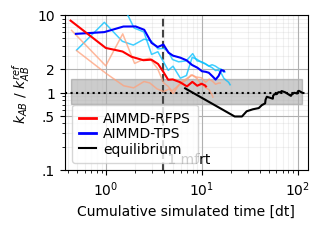

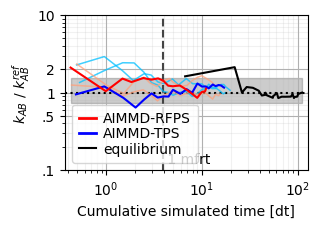

In [92]:
# kAB plot
initialize_plot()

# AIMMD (TPS) estimates
for i in range(4, 6):
    plt.plot(times[i], kAB[i] / kAB0[-1],
             color=AIMMD_TPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[3], kAB[3] / kAB0[-1],
         color=AIMMD_TPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# RFPS-AIMMD estimates
for i in range(1, 3):
    plt.plot(times[i], kAB[i] / kAB0[-1],
             color=AIMMD_RFPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[0], kAB[0] / kAB0[-1],
         color=AIMMD_RFPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# equilibrium reference estimates
plt.plot(0,0, lw=2, color=AIMMD_RFPS_front_color, label='RFPS-AIMMD')
plt.plot(0,0, lw=2, color=AIMMD_TPS_front_color, label='AIMMD')
plt.fill_between([np.min(times), times0[-1]],
                 np.repeat(kAB0_min[-1]/kAB0[-1], 2),
                 np.repeat(kAB0_max[-1]/kAB0[-1], 2),
                 alpha=.2, color='black')
plt.plot(times0[4::2], kAB0[4::2]/kAB0[-1],
         color=EQ_color, label='equilibrium')


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.grid(which='minor', alpha=.167)
plt.legend(labelspacing=.1,
           borderpad=.5,
           handletextpad=.5,
           handlelength=1.25,
          loc='lower left')

ax = plt.gca()
ax.margins(0.025)
xlim = ax.get_xlim()
ax.axhline(1., color='black', linestyle=':', zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(.1, 10)
plt.ylim(.1, 10)
ax.set_yticks([.1,.5, 1, 2, 10],['.1', '.5', '1', '2', '10'])
plt.xlabel('Cumulative simulated time [dt]')
plt.ylabel('$k_{AB}~/~k_{AB}^{ref}$')
plt.axvline(mfrt, linestyle='--', color='#444444', zorder=2)
plt.text(mfrt, .12, ' 1 mfrt', ha='left')
plt.savefig(f'figures/{name}_kAB.pdf')

# kBA plot
initialize_plot()

# AIMMD (TPS) estimates
for i in range(4, 6):
    plt.plot(times[i], kBA[i] / kBA0[-1],
             color=AIMMD_TPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[3], kBA[3] / kBA0[-1],
         color=AIMMD_TPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# RFPS-AIMMD estimates
for i in range(1, 3):
    plt.plot(times[i], kBA[i] / kBA0[-1],
             color=AIMMD_RFPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[0], kBA[0] / kBA0[-1],
         color=AIMMD_RFPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# equilibrium reference estimates
plt.plot(0,0, lw=2, color=AIMMD_RFPS_front_color, label='RFPS-AIMMD')
plt.plot(0,0, lw=2, color=AIMMD_TPS_front_color, label='AIMMD')
plt.fill_between([np.min(times), times0[-1]],
                 np.repeat(kBA0_min[-1]/kBA0[-1], 2),
                 np.repeat(kBA0_max[-1]/kBA0[-1], 2),
                 alpha=.2, color='black')
plt.plot(times0[4::2], kBA0[4::2]/kBA0[-1],
         color=EQ_color, label='equilibrium')


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.grid(which='minor', alpha=.167)
plt.legend(labelspacing=.1,
           borderpad=.5,
           handletextpad=.5,
           handlelength=1.25,
          loc='lower left')

ax = plt.gca()
ax.margins(0.025)
xlim = ax.get_xlim()
ax.axhline(1., color='black', linestyle=':', zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(.1, 10)
plt.ylim(.1, 10)
ax.set_yticks([.1,.5, 1, 2, 10],['.1', '.5', '1', '2', '10'])
plt.xlabel('Cumulative simulated time [dt]')
plt.ylabel('$k_{AB}~/~k_{AB}^{ref}$')
plt.axvline(mfrt, linestyle='--', color='#444444', zorder=2)
plt.text(mfrt, .12, ' 1 mfrt', ha='left')
plt.savefig(f'figures/{name}_kBA.pdf')

### Plot committor model error

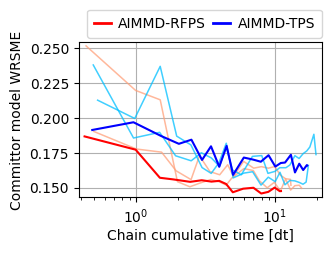

In [89]:
initialize_plot()

# RFPS-AIMMD
for i in range(1, 3):
    plt.plot(times[i], pB_error[i],
             color=AIMMD_RFPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[0], pB_error[0],
         color=AIMMD_RFPS_front_color, lw=1.5,
         zorder=20, alpha=1)

# AIMMD (TPS)
for i in range(4, 6):
    plt.plot(times[i], pB_error[i],
             color=AIMMD_TPS_back_color, lw=1.1,
             zorder=10, alpha=.75)
plt.plot(times[3], pB_error[3],
         color=AIMMD_TPS_front_color, lw=1.5,
         zorder=20, alpha=1)

plt.gca().set_xscale('log')
plt.grid()
ax = plt.gca()
ax.margins(0.025)
plt.plot(0,0.15, lw=2, color='red', label='RFPS-AIMMD')
plt.plot(0,0.15, lw=2, color='blue', label='AIMMD')

plt.legend(labelspacing=.1,
           columnspacing=0.5,
           borderpad=.5,
           handletextpad=.5,
           handlelength=1.25, ncol=2, loc=(0.034,1.03))

plt.xlabel('Chain cumulative time [dt]', labelpad=2.5)
plt.ylabel('Committor model WRSME')
plt.savefig(f'figures/{name}_pB_error.pdf')